In [1]:
import requests
import io
import os
import pandas as pd
import datetime
import pathlib
import csv
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
 def get_clickhouse_data(query, host, connection_timeout=1500):
    r = requests.post(host, params = {'query': query}, timeout = connection_timeout)
    if r.status_code == 200:
        return r.text
    else:
        raise Exception(r.text)


def get_clickhouse_rows(query, host, connection_timeout=1500):
    data = get_clickhouse_data(query, host, connection_timeout) 
    if data != '':
        return data
    return ''

In [3]:
server_address = 'http://bigdata1-chel2.is74.ru:3307'

%%time

request = f"""
           SELECT round(modulo(toUInt32(clock),86400)/72,0) as intv, avg(value) FROM zabbix_service.history 
           WHERE day =toDate('2019-07-21') AND 
           itemid=6704572
           GROUP BY intv
           ORDER BY intv
            """
rows = get_clickhouse_rows(request, server_address, connection_timeout=10000)


In [29]:
%%time

request = f"""
           SELECT * FROM zabbix_service.history 
           WHERE day =toDate('2019-07-21') AND 
           itemid=6704572
           ORDER BY clock
           LIMIT 2000
            """
rows = get_clickhouse_rows(request, server_address, connection_timeout=10000)


Wall time: 102 ms


Посмотрим сколько данных за день

In [30]:
tmp_df = pd.read_csv(io.StringIO(rows), sep = '\t', names=['date', 'itemid', 'clock', 'ns', 'value_int','value_dbl','value_str'], quoting=csv.QUOTE_NONE)

In [32]:
tmp_df.head()

date   itemid                clock         ns  value_int  value_dbl  \
0  2019-07-21  6704572  2019-07-21 00:02:56  543907536        186          0   
1  2019-07-21  6704572  2019-07-21 00:07:56  165732706          2          0   
2  2019-07-21  6704572  2019-07-21 00:12:56  465077620          3          0   
3  2019-07-21  6704572  2019-07-21 00:17:56  720166281          2          0   
4  2019-07-21  6704572  2019-07-21 00:22:56  850546950          2          0   

   value_str  
0        NaN  
1        NaN  
2        NaN  
3        NaN  
4        NaN

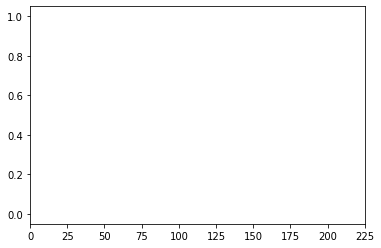

In [9]:
vals.plot()

lets try to build a median graph for 7 days

In [10]:
seazon=86400
gran = 180


Wall time: 74 ms


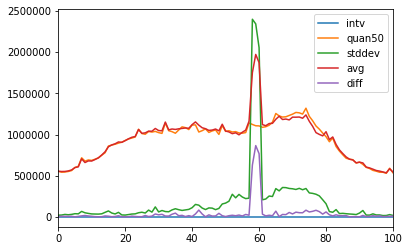

In [11]:
%%time

med_request = f"""
           SELECT round(modulo(toUInt32(clock),86400)/864,0) as intv, quantile(0.50)(value) as qnt,
                   stddevSamp(value),avg(value) as avg,
                   abs(qnt-avg)
           FROM zabbix_service.history 
           WHERE day >= toDate('2019-07-14') AND 
            day <= toDate('2019-07-21') AND 
           itemid=1441220 
           GROUP BY intv
           ORDER BY intv
            """
m_rows = get_clickhouse_rows(med_request, server_address, connection_timeout=10000)
med_df = pd.read_csv(io.StringIO(m_rows), sep = '\t', names=['intv', 'quan50', 'stddev','avg','diff'], quoting=csv.QUOTE_NONE)
#med_df.head(10)
med_df.plot();


now, preparing the query which will select the data and aggregaete it with the season periodicity granular to gran points per seazon

#lets build metrics for "normal" period

In [33]:
%%time
med_calc_anomaly =f""" select itemid, sum(ddf) as sd,
                             sum(qnt) as sq, (sd/sq) as ad  from (
           SELECT itemid, round(modulo(toUInt32(clock),86400)/864,0) as intv, quantile(0.50)(value) as qnt,
                   stddevSamp(value),avg(value) as avg,
                   abs(qnt-avg) as ddf
           FROM zabbix_service.history 
           WHERE day >= toDate('2019-07-12') and 
           day <= toDate('2019-07-19') and 
           itemid < 200000000
           GROUP BY intv,itemid
           ORDER BY intv) where ddf>0 and qnt > 0 group by itemid order by ad desc
            """
m_rows = get_clickhouse_rows(med_calc_anomaly, server_address, connection_timeout=10000)

Wall time: 37.8 s


In [34]:
med_anom = pd.read_csv(io.StringIO(m_rows), sep = '\t', names=['itemid', 'sd', 'sq','ad'], quoting=csv.QUOTE_NONE)

In [35]:
print (m_rows[0:200])


2341426	51784705197.01064	12928	4005623.8549667886
2599153	52763640467.52889	14544	3627863.0684494562
2483528	10805292216.611198	4320	2501225.050141481
2341458	11238252647.639334	4848	2318121.4207176846
2599119	11795993061.38411	5656	2085571.616227742
2566837	873343367.4245634	1664	524845.7736926463
2566825	873430795.272785	1728	505457.636153232
2483492	2448144305.2015405	7176	341157.2331663239
1924864	2432618395.410807	23032	105619.06892196974
2284053	3182123478.12769	30696	103665.73749438656
2797814	2712187976.740782	30400	89216.70976120993
2483527	2450564902.443393	27684	88519.17723029162
2798140	5501455127.567026	65844	83552.86932092562
2278887	5494893919.1086445	69932	78574.81437837677
2273175	2737362660.7832494	38340	71397.04383889539
2797815	2682873227.2661753	37888	70810.63205411147
2284071	894736066.9795159	13744	65100.12128779947
2607798	856525212.4456838	13736	62356.23270571373
2273187	887670439.3430567	16968	52314.38232809151
2607797	877327840.1424884	16968	51704.8467787888

itemid            sd            sq            ad
count  5.587400e+04  5.587400e+04  5.587400e+04  5.587400e+04
mean   5.544227e+06  7.018623e+12  9.880059e+13  3.290586e+02
std    1.733051e+07  1.657623e+15  2.311685e+16  2.867131e+04
min    2.341500e+04  1.572327e-03  5.000000e-01  7.997895e-11
25%    2.188993e+06  1.728652e+02  1.691125e+03  1.734971e-02
50%    2.627968e+06  2.155596e+04  1.897970e+05  6.688149e-02
75%    2.903175e+06  6.423889e+06  4.015577e+07  3.372643e-01
max    1.866035e+08  3.918237e+17  5.464256e+18  4.005624e+06

In [55]:
%%time
med_calc_fail =f""" select itemid, sum(ddf) as sd,
                             sum(qnt) as sq, (sd/sq) as ad  from (
           SELECT itemid, round(modulo(toUInt32(clock),86400)/864,0) as intv, quantile(0.50)(value) as qnt,
                   stddevSamp(value),avg(value) as avg,
                   abs(qnt-avg) as ddf
           FROM zabbix_service.history 
           WHERE day = toDate('2019-07-20') and
           itemid < 200000000
           GROUP BY intv,itemid
           ORDER BY intv) where ddf>0 and qnt > 0 group by itemid order by ad desc
            """
m_fail_rows = get_clickhouse_rows(med_calc_fail, server_address, connection_timeout=10000)

Wall time: 19.7 s


In [56]:
med_fail_anom = pd.read_csv(io.StringIO(m_fail_rows), sep = '\t', names=['itemid', 'fsd', 'fsq','fad'], quoting=csv.QUOTE_NONE)
med_fail_anom.head()

itemid           fsd      fsq           fad
0  77834785  5.194900e+05     14.0  37106.428571
1   2518738  4.783624e+06   2253.0   2123.223998
2   2414704  1.985667e+03      1.0   1985.666667
3   2553434  1.034804e+08  56384.0   1835.280032
4   2172230  1.347667e+03      1.0   1347.666667

Combininig two dataframes

In [57]:
merged_f = pd.merge(left=med_fail_anom,right=med_anom, left_on='itemid', right_on='itemid')

In [58]:
merged_f.head(1000)



itemid           fsd         fsq          fad            sd  \
0     2518738  4.783624e+06      2253.0  2123.223998  6.104209e+02   
1     2414704  1.985667e+03         1.0  1985.666667  2.952526e+02   
2     2553434  1.034804e+08     56384.0  1835.280032  1.178183e+08   
3     2172230  1.347667e+03         1.0  1347.666667  1.997675e+02   
4     7608075  1.345333e+03         1.0  1345.333333  1.844825e+02   
5     7608077  1.345333e+03         1.0  1345.333333  1.845033e+02   
6     1028733  5.116101e+06      5040.0  1015.099471  5.978329e+06   
7     2103398  1.053808e+08    115344.0   913.621908  3.889890e+07   
8     2872760  1.742667e+03         2.0   871.333333  2.293161e+02   
9     2872761  1.742667e+03         2.0   871.333333  2.294203e+02   
10    2928113  7.500000e+02         1.0   750.000000  4.827192e+02   
11    2104894  9.283113e+07    141104.0   657.891522  3.805646e+07   
12    2918428  6.647273e+07    124056.0   535.828422  1.025546e+07   
13    2124947  6.574790e+07    125296.0   524.740625  8.348919e+06   
14    2824313  7.139312e+07    153192.0   466.036886  4.442101e+07   
15    7608066  1.587381e+07     35232.0   450.550787  2.022696e+06   
16   77798779  8.332933e+04       203.0   410.489327  1.828871e+04   
17    7608068  1.587407e+07     39704.0   399.810397  2.108311e+06   
18    2172224  1.587127e+07     44960.0   353.008778  2.380455e+06   
19    2413926  4.185851e+07    128808.0   324.968284  6.594563e+06   
20    2775659  1.274183e+07     40840.0   311.993928  6.836285e+06   
21    2414730  8.340000e+02         3.0   278.000000  1.758774e+02   
22    2257679  1.054333e+03         4.0   263.583333  3.961731e+02   
23    2632613  3.701878e+07    140584.0   263.321459  5.719778e+06   
24    2918537  1.353000e+03         6.0   225.500000  3.195284e+02   
25   11657877  2.546800e+05      1200.0   212.233333  3.402430e+05   
26    2928101  9.030795e+06     48776.0   185.148324  5.589779e+06   
27    2553443  8.552667e+03        47.0   181.971631  9.743339e+03   
28    2257619  1.279389e+07     71264.0   179.528027  4.336102e+06   
29    2094479  3.601013e+05      2136.0   168.586767  6.804362e+05   
..        ...           ...         ...          ...           ...   
970   2290316  3.787200e+05    266536.0     1.420896  3.693950e+07   
971   2902681  8.013333e+03      5640.0     1.420804  3.828828e+07   
972   3015372  5.188000e+04     36544.0     1.419658  8.207183e+04   
973   2935639  1.808333e+03      1274.0     1.419414  2.882113e+03   
974   2975118  7.603360e+05    535928.0     1.418728  2.825548e+06   
975   2387565  1.684800e+04     11896.0     1.416274  1.455338e+06   
976   2016857  7.766667e+01        55.0     1.412121  7.148665e+02   
977   2936197  1.527665e+07  10821016.0     1.411758  4.947646e+06   
978   2657573  2.026667e+02       144.0     1.407407  1.434818e+04   
979   2600741  6.588107e+05    468256.0     1.406945  3.674159e+06   
980   1652826  3.356667e+02       239.0     1.404463  6.683686e+02   
981   1555005  2.441547e+05    174104.0     1.402350  4.470991e+05   
982   2179220  7.663333e+02       547.0     1.400975  1.305460e+03   
983   2904331  7.690347e+05    550232.0     1.397655  1.653363e+07   
984   2580615  9.354694e+05    670218.5     1.395768  1.215532e+06   
985   2904197  1.533333e+01        11.0     1.393939  9.900451e+01   
986   1777286  3.524587e+05    253432.0     1.390743  4.385714e+05   
987   1879005  2.687200e+04     19328.0     1.390315  3.478058e+04   
988  37545495  2.103410e+07  15133248.0     1.389926  2.537855e+07   
989   2647310  5.729101e+05    413563.0     1.385303  1.893608e+06   
990   2658396  4.385496e+06   3174760.0     1.381363  1.005376e+08   
991   1953565  3.647160e+06   2640536.0     1.381220  4.203187e+06   
992   1777278  3.516560e+05    254640.0     1.380993  4.386101e+05   
993   2902742  9.253253e+05    670416.0     1.380226  2.454432e+07   
994   2402180  1.055893e+05     76616.0     1.378163  1.783303e+05   
995   2729044  1.

In [84]:
filtered_df=merged_f[merged_f.sd < 1 ]

In [85]:
filtered_df.head(100)

itemid        fsd   fsq        fad        sd    sq        ad
112    2275328  74.333333   3.0  24.777778  0.401268   5.5  0.072958
424    2275073   7.333333   2.0   3.666667  0.500000   0.5  1.000000
865    2961119   3.333333   2.0   1.666667  0.750000   0.5  1.500000
1068   2851632   1.285714   1.0   1.285714  0.617647   4.0  0.154412
1460   2275096   7.666667   8.0   0.958333  0.689312   7.0  0.098473
1498   2402403   4.666667   5.0   0.933333  0.500000   1.0  0.500000
2100   2018764  21.666667  32.0   0.677083  0.130435   1.0  0.130435
2126   2178832   2.000000   3.0   0.666667  0.500000   2.0  0.250000
2130   1047842   0.666667   1.0   0.666667  0.549242   5.0  0.109848
2133   3022021   1.333333   2.0   0.666667  0.604167   2.5  0.241667
2147   2811178   1.333333   2.0   0.666667  0.041667   0.5  0.083333
2149   2811183   1.333333   2.0   0.666667  0.083333   0.5  0.166667
2199   2724986   1.314286   2.0   0.657143  0.364916   4.0  0.091229
2337   2873609   8.666667  14.0   0.619048  0.708333   1.0  0.708333
2676   2858649  20.333333  37.0   0.549550  0.250000   1.5  0.166667
3437   2583054   0.866667   2.0   0.433333  0.405357   5.0  0.081071
3438   2780774   0.866667   2.0   0.433333  0.455952   5.0  0.091190
3481   2580426   0.857143   2.0   0.428571  0.433231   3.0  0.144410
3764   1819228   1.200000   3.0   0.400000  0.363801   9.0  0.040422
3809   2946436   1.585714   4.0   0.396429  0.758929   2.5  0.303571
3964   2975272   5.000000  13.0   0.384615  0.886905   2.0  0.443452
4324  12531727   0.357143   1.0   0.357143  0.054526   4.0  0.013632
4325  12531787   0.357143   1.0   0.357143  0.138560   5.0  0.027712
4705   4480749   2.333333   7.0   0.333333  0.166667   1.0  0.166667
4710   2492042  11.666667  35.0   0.333333  0.333333   1.0  0.333333
4720   1257772   2.666667   8.0   0.333333  0.750000   2.0  0.375000
4768   2591234   0.333333   1.0   0.333333  0.820833   2.5  0.328333
4770   2095843   0.333333   1.0   0.333333  0.041667   1.0  0.041667
4773   2275533   1.333333   4.0   0.333333  0.291667   1.0  0.291667
4786   2679278   0.333333   1.0   0.333333  0.333333   1.0  0.333333
...        ...        ...   ...        ...       ...   ...       ...
5205   2977121   0.333333   1.0   0.333333  0.666667   8.0  0.083333
5209   2975629   0.333333   1.0   0.333333  0.583333   7.0  0.083333
5225   2307769   0.333333   1.0   0.333333  0.750092  15.0  0.050006
5237  10940730   0.333333   1.0   0.333333  0.844720  12.0  0.070393
5241   1575464   0.333333   1.0   0.333333  0.812500  13.0  0.062500
5249   2975489   0.333333   1.0   0.333333  0.645833  10.0  0.064583
5251   2608215   0.666667   2.0   0.333333  0.798913   8.0  0.099864
5252   2307086   0.333333   1.0   0.333333  0.670290  10.0  0.067029
5256   2402591   0.333333   1.0   0.333333  0.250000   1.0  0.250000
5258   2016877   0.333333   1.0   0.333333  0.507246   6.0  0.084541
5291   2971057   0.333333   1.0   0.333333  0.416667   7.0  0.059524
5294   2715212   0.333333   1.0   0.333333  0.166667   0.5  0.333333
5418   2580438   1.328571   4.0   0.332143  0.127119   1.0  0.127119
5464   2580266   4.604762  14.0   0.328912  0.836905   2.5  0.334762
5553   1819225   4.842857  15.0   0.322857  0.309099  15.0  0.020607
6018   3022975   2.404762   8.0   0.300595  0.333333   1.0  0.333333
6116   2975275   5.333333  18.0   0.296296  0.541667   2.0  0.270833
6197   2977180   2.333333   8.0   0.291667  0.625000   0.5  1.250000
6258   2617723   4.333333  15.0   0.288889  0.885870   2.0  0.442935
6347   2917046   2.000000   7.0   0.285714  0.596014   2.0  0.298007
6348  12531916   0.285714   1.0   0.285714  0.034524   3.0  0.011508
6349   1677817   0.285714   1.0   0.285714  0.400076   3.0  0.133359
6350   2580454   0.285714   1.0   0.285714  0.892857   2.0  0.446429
6351   1555667   0.285714   1.0   0.285714  0.340797   3.0  0.113599
6352   1555660   0.285714   1.0   0.285714  0.342252   3.0  0.114084
6356   2851485   0.285714   1.0   0.285714  0.380952   1.0  0.380952
6430  